In [ ]:
# Importing required libraries

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm 
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Using GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Defining parameters

num_epochs =7
learning_rate = 0.001
input_size = 28
hidden_size=128
num_layers = 2
num_classes = 10
sequential_length=28
batch_size=100

In [ ]:
# Loading train and test datasets 

train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [ ]:
# Loading train and test datasets 

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
print(train_dataset)
print("\n")
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Neural Network

In [ ]:
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers, num_classes):
    super(LSTM,self).__init__()
    self.input_size=input_size
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.num_classes=num_classes

    self.LSTM=nn.LSTM(input_size, hidden_size, num_layers,batch_first=True)
    self.fc=nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    h0=torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    lstm_out, (h_out, c_out) = self.LSTM(x, (h0, c0))
  
    lstm_out =lstm_out[:, -1, :]

    output = self.fc(lstm_out)
 


    return output

In [ ]:
# Defining model

model=LSTM(input_size, hidden_size,num_layers, num_classes).to(device) 

In [ ]:
# Determining loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
n_iterations=len(train_loader)

# TRAINING

train_loss_list=[]
test_loss_list=[]
accuracy_list=[]
for epoch in range(num_epochs):
  loss_total_train=0
  label_list=[]
  for i,(images,labels) in enumerate(train_loader):
     images = images.reshape(-1, sequential_length, input_size).to(device) 
     labels=labels.to(device) 

     #forward pass
     train_output=model(images)
     optimizer.zero_grad()

     #loss
     train_loss=criterion(train_output,labels)
     loss_total_train+=train_loss

     #backward pass
     train_loss.backward()

     #update
     optimizer.step()

  avg_train_loss=loss_total_train/n_iterations

  # PREDICTION AND EVALUATION
  with torch.no_grad(): 
        score=0
        n_samples=0
        loss_total_test=0
        output_list=[]
        for images,labels in test_loader:
          images = images.reshape(-1, sequential_length, input_size).to(device)  
          labels=labels.to(device) 
          label_list.extend(labels.numpy())

          test_output=model(images)
          value, index = torch.max(test_output.data, 1)
          predicted_labels=index

          n_samples+=labels.size(0)
          correct_pred=(predicted_labels == labels)
          score+=correct_pred.sum()
          output_list.extend(predicted_labels.numpy())

          #test loss
          test_loss=criterion(test_output,labels)
          loss_total_test+=test_loss
        accuracy= score/n_samples*100

        avg_train_loss=loss_total_train/n_iterations
        avg_test_loss=loss_total_test/n_iterations

        accuracy_list.append(accuracy.numpy())
        train_loss_list.append(avg_train_loss.numpy())
        test_loss_list.append(avg_test_loss.numpy())
       


  print (f"Epoch [{epoch+1}/{num_epochs}]: \n train loss= {avg_train_loss:.5f}\n test loss= {avg_test_loss:.5f}\n\n")
print(f"Accuracy:% {accuracy:.2f}")


Epoch [1/7]: 
 train loss= 0.49497
 test loss= 0.02446


Epoch [2/7]: 
 train loss= 0.12292
 test loss= 0.01529


Epoch [3/7]: 
 train loss= 0.07794
 test loss= 0.01111


Epoch [4/7]: 
 train loss= 0.05930
 test loss= 0.00946


Epoch [5/7]: 
 train loss= 0.04863
 test loss= 0.01284


Epoch [6/7]: 
 train loss= 0.04106
 test loss= 0.00726


Epoch [7/7]: 
 train loss= 0.03645
 test loss= 0.00970


Accuracy:% 98.23


### Model Evaluation

#### Train loss, test loss, accuracy graphs

Text(0.5, 0, 'Epoch number')

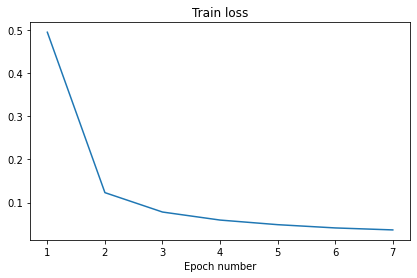

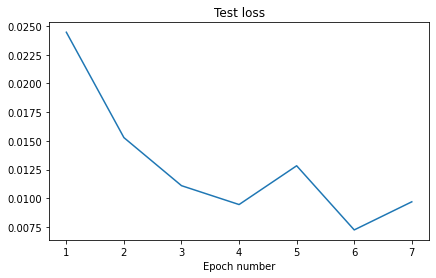

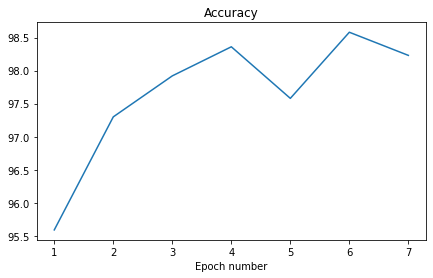

In [ ]:
plt.figure(1, figsize=(6.81, 4))
plt.plot(np.arange(1,8,1),train_loss_list)
plt.title('Train loss')
plt.xlabel('Epoch number')

plt.figure(2,figsize=(6.81, 4))
plt.plot(np.arange(1,8,1),test_loss_list)
plt.title('Test loss')
plt.xlabel('Epoch number')

plt.figure(3,figsize=(6.98, 4))
plt.plot(np.arange(1,8,1),accuracy_list)
plt.title('Accuracy')
plt.xlabel('Epoch number')


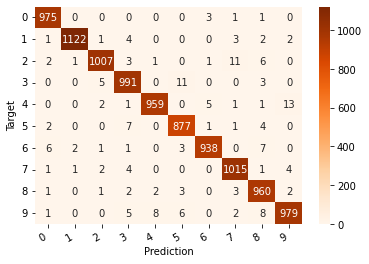

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Oranges")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Target')
  plt.xlabel('Prediction');

class_names = [0,1,2,3,4,5,6,7,8,9]
cm = confusion_matrix(label_list, output_list)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(label_list, output_list))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

